## Problem Set 3: Merging and Regular Expressions, Part 1


**Background on the policy context**: here, we're going to use two datasets to practice reshaping, merging, and regular expression patterns. Both datasets relate to the broader issue of which employers might be violating the rights of temporary guestworkers granted visas under the H-2A program. Here are some articles about potential exploitation of guestworkers by firms and inequality caused by minimal oversight:

- News media coverage of labor abuses of temporary guestworkers: https://www.buzzfeednews.com/article/kenbensinger/the-pushovers 
- GAO report on labor abuses of temporary guestworkers: https://www.gao.gov/products/gao-15-154

The following datasets are located in `pset3_inputdata` (need to unzip): 

- `jobs`: a dataset of guestworker jobs posted by many employers, some of whom have been debarred (banned) from the program for labor abuses; others not debarred
- `debar`: a dataset of employers who committed violations of labor regulations meant to protect temporary guestworkers 


Here's a codebook explaining the variables in `jobs.csv`: https://web.archive.org/web/20231129014506/https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/H-2A_Record_Layout_FY2023_Q4.pdf


In [2]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import os

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Reshaping data (13 points total)

Load the following dataset stored in `pset3_inputdata`: `debar.csv`

This represents employers temporarily banned from hiring workers (debar.csv); call this `debar`


View the head()


In [4]:
debar = pd.read_csv("pset3_inputdata/debar.csv")
debar.head()

,Name,"City, State",Violation,Duration,Start date,End date
0,J&J Harvesting,"Leads, ND",Failure to respond to audit (partial response),2 years,1/19/2014,1/18/2016
1,"Stahlman Apiaries, Inc","Selby, SD",Failure to respond to audit (partial response),1 year,2/19/2015,2/14/2016
2,Trust Nursery,"Pulaski, NY",Failure to respond to audit (partial response),1 year,3/21/2014,3/20/2015
3,Anton Fertilizer Inc.,"Dighton, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016
4,"Great Plains Fluid Service, Inc.","Greensburg, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016


## 1.1 (1 point)

Print the number of rows in `debar` versus the number of unique employer names (`Name`). Is there one row per employer or multiple rows for some employers?

In [5]:
debar["Name"].nunique()
debar["Name"].value_counts()
len(debar)

#There are more rows than employers

98

Name
Maple Ridge Custom Services, LLC           2
Loewen Harvesting LLC                      2
Old Tree Farms/Verpaalen Custom Service    2
Dove Creek Farms                           2
Cisco Produce Inc.                         2
                                          ..
Glenda Harrod Farms                        1
Chris Robinson                             1
Haiti/USA Workforce, LLC                   1
Leonard Smith Farms                        1
Delia Rojas                                1
Name: count, Length: 98, dtype: int64

114

## 1.2 Investigating duplicated rows (2 points)

A. Create a new column in `debar`--`is_repeated`-- that tells us whether an employer (`Name`) is repeated > 1 times

*Hint*: there are multiple ways to solve this but some possibilities to get the list of names that are repeated are:
- Using value_counts() on the `Name` variable and extracting the index from that value counts 
- Using groupby to count the rows attached to one name

B. Print the rows where `is_repeated == True` and interpret

C. Subset to the rows where `is_repeated == True` and save that data as `mult_debar`. Print the head() and shape

In [6]:
#Make list of names, and then another list to add repeatred names
all_names=[]
repeated_names=[]
#For loop that distinguishes all the names that appear twice by checking if they've been in the list of iterated names already
for name in debar["Name"]:
    if name not in all_names:
        all_names.append(name)
    else:
        repeated_names.append(name)

#Some names might be repeated twice, so make a set to get one value each and convert that back into a list to us .isin
repeated_names = list(set(repeated_names))

#Add to new row
debar["is_repeated"] = debar["Name"].isin(repeated_names)

#Where the name is repeated
print(debar[debar["is_repeated"]==True])
#Interpreation: This shows all the employers that have engaged in repeated violations, such that they have multiple entries on the list

#Subset data to where its true
mult_debar = debar[debar["is_repeated"]==True]
mult_debar.head()
mult_debar.shape

                                        Name       City, State  \
6                    Annabella Land & Cattle     Annabella, UT   
7                        Autumn Hill Orchard        Groton, MA   
8      Caddo Creek Ranch, dba Paradise Ranch         Caddo, TX   
11                     Loewen Harvesting LLC   Brownsville, TX   
12               Rollo Farm Labor Contractor         Miami, FL   
14                             Sharon Mathis        Tifton, GA   
15                                 SRT Farms        Morton, TX   
16                               Mark Duncan     Roosevelt, UT   
17          Maple Ridge Custom Services, LLC     Altheimer, AK   
18                                 F&W Farms       Ingalls, KS   
19                        Cisco Produce Inc.         Cairo, GA   
21   Old Tree Farms/Verpaalen Custom Service         Volga, SD   
24               Rollo Farm Labor Contractor         Miami, FL   
25                     Loewen Harvesting LLC    Brownfield, TX   
28     Cad

,Name,"City, State",Violation,Duration,Start date,End date,is_repeated
6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,True
7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,True
8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,True
11,Loewen Harvesting LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,True
12,Rollo Farm Labor Contractor,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,True


(32, 7)

## 1.3 Reshape mult_debar to wide to begin filtering out duplicates (4 points)

You want to separate out two cases:

- Cases where the repeat rows for one employer are due to duplicated data 
- Cases where the repeat rows for one employer represent repeated violations for different issues

There are various ways to check duplicates in this data (eg converting `Violation` to lowercase; replacing spelled-out states with two-dig state codes)

We're going to use the simple rule of:

- A row is a duplicate if, within an employer (defined by Name + City, State), the Start date for each row's violation is the same 

To begin to check this, reshape `mult_debar` to a wide dataframe (`mult_debar_wide`) with the following columns, treating the `Name` and `City, State` as the index for the pivot:

- Name
- City, State
- start_date_viol1
- start_date_viol2

Print the head and shape

In [14]:
#Goes through the long table, and seperates each violation out by the number of it using group by and counting amount in that group by
mult_debar["number_of_violation"] = mult_debar.groupby(["Name", "City, State"]).cumcount() + 1

#Make the wide table
mult_debar_wide = mult_debar.pivot_table(
    index=["Name", "City, State"],
    columns="number_of_violation",
    values="Start date",
    aggfunc="first"
)
#Creates variables for the first and second indexes assigned them to the first and second violations
mult_debar_wide["start_date_viol1"] = mult_debar_wide[1]
mult_debar_wide["start_date_viol2"] = mult_debar_wide[2]

#print(mult_debar_wide["start_date_viol2"])

print(mult_debar_wide.head())
print(mult_debar_wide.shape)



number_of_violation                                            1         2  \
Name                                  City, State                            
Annabella Land & Cattle               Annabella, UT     5/9/2014       NaN   
                                      Annabella, Utah   5/9/2014       NaN   
Autumn Hill Orchard                   Groton, MA        7/6/2014  7/6/2014   
Caddo Creek Ranch, dba Paradise Ranch Caddo, TX        7/20/2014       NaN   
                                      Caddo, Texas     7/20/2014       NaN   

number_of_violation                                   start_date_viol1  \
Name                                  City, State                        
Annabella Land & Cattle               Annabella, UT           5/9/2014   
                                      Annabella, Utah         5/9/2014   
Autumn Hill Orchard                   Groton, MA              7/6/2014   
Caddo Creek Ranch, dba Paradise Ranch Caddo, TX              7/20/2014   
         

/var/folders/dy/p704dsds00s4ljxfm66_km9r0000gn/T/ipykernel_10250/1030420215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mult_debar["number_of_violation"] = mult_debar.groupby(["Name", "City, State"]).cumcount() + 1


## 1.4 Filter out duplicates from original debar data (6 points)

A. Using `mult_debar_wide`, add a column `is_dup` that takes value of True for cases where start_date_viol1 == start_date_viol2 marking the row as a duplicate

B. Going back to the original long-format data you loaded at the beginning -- `debar`

    - Create a column in `debar` called `violnum` that numbers the violations for each employer (so the first violation for an employer is 1, the second is 2, etc)
    - For employers where `is_dup == True` as indicated by your wide-format dataframe, only keep `violnum == 1`
    - For all other employers (so is_dup == False and ones we didnt need to check duplicates for), keep all violnum
    - Remove the `is_repeated` column from the `debar` data

**Hint**: you can complete part B without a for loop; `pd.concat` with axis = 0 (row binding) is one way

Call the resulting dataframe `debar_clean` and print the shape and # of unique employer names

Save the `debar_clean` as a csv file using `df.to_csv([filename], index=False)`. You will be using it in Problem Set 4.

In [ ]:
#A) is_dup in wide
temp = mult_debar_wide.copy()

#bring the name+city out of index
temp = temp.reset_index()

#find duplicates
temp["is_dup"] = temp["start_date_viol1"].eq(temp["start_date_viol2"])

#make the set of duplicatate employers (got outside assistance)
dup_employers = set(
    temp.loc[temp["is_dup"], ["Name", "City, State"]]
    .drop_duplicates()
    .itertuples(index=False, name=None)
)

# B) clean long debar using violnum + concat
debar2 = debar.copy()

# Make sure Start date is datetime so violnum is meaningful
debar2["Start date"] = pd.to_datetime(debar2["Start date"], errors="coerce")

# Create violnum within employer (Name, City, State), ordered by Start date
debar2 = debar2.sort_values(["Name", "City, State", "Start date"])
debar2["violnum"] = debar2.groupby(["Name", "City, State"]).cumcount() + 1

# Flag rows that belong to a duplicate employer 
debar2["is_dup_employer"] = list(zip(debar2["Name"], debar2["City, State"]))
debar2["is_dup_employer"] = debar2["is_dup_employer"].isin(dup_employers)

# Split:
dup_part = debar2.loc[debar2["is_dup_employer"] & (debar2["violnum"] == 1)].copy()
nondup_part = debar2.loc[~debar2["is_dup_employer"]].copy()

# Row-bind back together
debar_clean = pd.concat([dup_part, nondup_part], axis=0, ignore_index=True)

# Remove is_repeated and helper column
debar_clean = debar_clean.drop(columns=["is_repeated", "is_dup_employer"], errors="ignore")


# Save
debar_clean.to_csv("debar_clean.csv", index=False)

#Check
print(debar_clean.shape)
print(debar_clean["Name"].nunique())



(105, 7)
98


## 2. Optional extra credit 2 (up to 3 points)

- For 1 point extra credit, create a visualization with 1+ of the existing fields in either the raw `jobs` or `debar` data. We'll be showing cool visualizations in class so use your imagination! Options could include visualizing between-state or over-time variation

- For 3 points extra credit instead, geocode the employer addresses in `jobs` and plot the addresses of jobs as points overlaid on top of a map of Georgia 
    - **Note**: this extra credit involves Googling since we have not yet covered spatial data. 
        - For discussion of how to geocode addresses -> lat/long, see: https://www.natasshaselvaraj.com/a-step-by-step-guide-on-geocoding-in-python/ 
        - For discussion of plotting lat/long dots against a map, see this discussion of geopandas: https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    - Relevant columns include `EMPLOYER_ADDRESS_1` 
    - The geocoding might have a long runtime so feel free to implement it in a separate .py script that you submit alongside your notebook and to just read in the geocoded data

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='year'>

Text(0.5, 1.0, 'Number of Debarment Actions Over Time')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Number of Debarments')

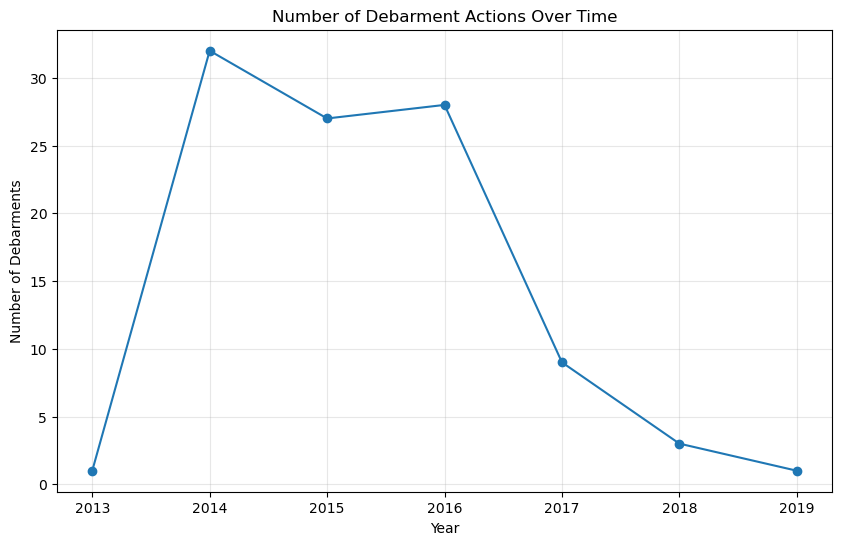

In [18]:
import matplotlib.pyplot as plt

#Make copy of clean data set and use date time
debar_plot = debar_clean.copy()
debar_plot["Start date"] = pd.to_datetime(debar_plot["Start date"], errors="coerce")

#Drop rows without valid dates
debar_plot = debar_plot.dropna(subset=["Start date"])
# Create year variable
debar_plot["year"] = debar_plot["Start date"].dt.year

#Group by year
debar_by_year = (debar_plot.groupby("year").size())

#plot
plt.figure(figsize=(10, 6))
debar_by_year.plot(kind="line", marker="o")

plt.title("Number of Debarment Actions Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Debarments")

plt.grid(True, alpha=0.3)
plt.show()